<a href="https://colab.research.google.com/github/Zero00502/Sonar-obj-detector/blob/main/Integrated_Object_Detection_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Loading and Preprocessing

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sierra022/sonar-imaging-mine-detection")

print("Path to dataset files:", path)

100%|██████████| 208M/208M [00:10<00:00, 21.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8


In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

In [3]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Set the base path based on your folder structure
base_path = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8'

# Define paths for the main train directory
train_images_path = os.path.join(base_path, 'train/train/images')
train_labels_path = os.path.join(base_path, 'train/train/labels')

# Ensure the train directories exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)

# Define dataset folders to consolidate into train
folders_to_merge = ['validation', 'test']

# Loop through the folders to merge data into the train folder
for folder in folders_to_merge:
    dataset_path = os.path.join(base_path, folder)

    # Paths for images and labels in the current folder
    images_path = os.path.join(dataset_path, 'images')
    labels_path = os.path.join(dataset_path, 'labels')

    # Move images to the train folder
    if os.path.exists(images_path):
        for image_file in os.listdir(images_path):
            src_image = os.path.join(images_path, image_file)
            dest_image = os.path.join(train_images_path, image_file)
            # Avoid overwriting files with the same name
            if os.path.exists(dest_image):
                print(f"Warning: {dest_image} already exists. Skipping.")
            else:
                shutil.move(src_image, dest_image)

    # Move labels to the train folder
    if os.path.exists(labels_path):
        for label_file in os.listdir(labels_path):
            src_label = os.path.join(labels_path, label_file)
            dest_label = os.path.join(train_labels_path, label_file)
            # Avoid overwriting files with the same name
            if os.path.exists(dest_label):
                print(f"Warning: {dest_label} already exists. Skipping.")
            else:
                shutil.move(src_label, dest_label)

    # Remove the folder after merging
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path, ignore_errors=True)
        print(f"Removed folder: {dataset_path}")

# Save the final train path in a variable
final_train_path = os.path.join(base_path, 'train/train')
print(f"Final train folder path: {final_train_path}")


Removed folder: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/test
Final train folder path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train


In [5]:
# Load and preprocess images
def load_image(image_path):
    """Loads an image and preprocesses it."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize
    return image

In [19]:
def parse_labels(label_path, img_width, img_height):
    """Parses a label file and converts bounding boxes to pixel coordinates."""
    objects = []
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")
    with open(label_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1]) * img_width
            y_center = float(values[2]) * img_height
            width = float(values[3]) * img_width
            height = float(values[4]) * img_height
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            objects.append((class_id, x1, y1, x2, y2))
    return objects

Image path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images/0002_2015.jpg
Label path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels/0002_2015.txt


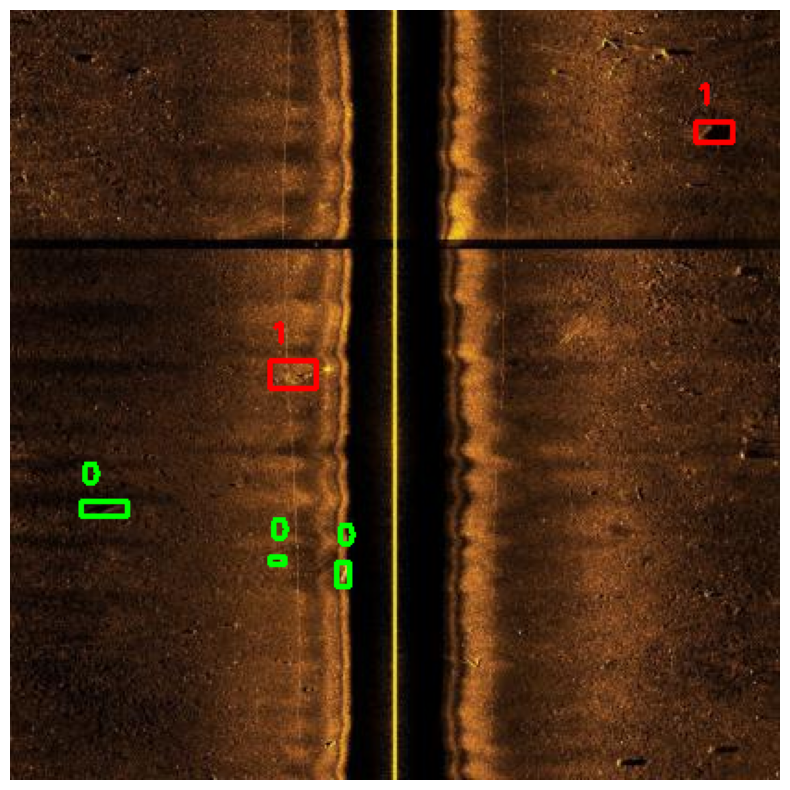

In [20]:
# Example: Load and display one image and its labels
image_path = os.path.join(train_images_path, "0002_2015.jpg")
label_path = os.path.join(train_labels_path, "0002_2015.txt")

# Debugging: Ensure paths are correct
print(f"Image path: {image_path}")
print(f"Label path: {label_path}")

# Load the image and parse the labels
image = load_image(image_path)
height, width, _ = image.shape
objects = parse_labels(label_path, width, height)

# Visualize labels on the image
for obj in objects:
    class_id, x1, y1, x2, y2 = obj
    color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image, f"{class_id}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

In [21]:
image_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images'
objects_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels'

# Prepare data
images = []
labels = []
max_objects = 0  # Keep track of the maximum number of annotations per image

for filename in os.listdir(image_dir):
  if filename.endswith('.jpg'):
    image_path = os.path.join(image_dir, filename)
    objects_file = os.path.join(objects_dir, filename[:-4] + '.txt')

    if os.path.exists(objects_file):
      img = cv2.imread(image_path)
      img = cv2.resize(img, (512, 512))  # Resize images to a consistent size
      images.append(img)
      objects = parse_labels(objects_file)

      # Update max_annotations if current image has more annotations
      max_objects = max(max_objects, len(objects))
      labels.append(objects)

TypeError: parse_labels() missing 2 required positional arguments: 'img_width' and 'img_height'

# Step 2: Binary Classification Model

In [4]:
padded_labels = []
for annotation_list in labels:
    # Pad with [0, 0, 0, 0, 0] to reach max_annotations length
    while len(annotation_list) < max_annotations:
        annotation_list.append([0, 0, 0, 0, 0])
    padded_labels.append(annotation_list)


# Convert lists to NumPy arrays
images = np.array(images)
# Use the padded labels instead of the original labels
labels = np.array(padded_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)


In [5]:
# Path to the training data directory
train_images_path = os.path.join(base_path, 'train/train/images')

# Create ImageDataGenerator instances
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    validation_split=0.2  # Reserve 20% for validation
)

# Create train and validation generators
train_generator = data_gen.flow_from_directory(
    directory=train_images_path,
    target_size=(512, 512),  # Resize images to (512, 512)
    batch_size=32,
    class_mode="binary",  # For binary classification
    subset="training"
)

validation_generator = data_gen.flow_from_directory(
    directory=train_images_path,
    target_size=(512, 512),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [6]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the binary classification model
binary_model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(512, 512, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")  # Sigmoid for binary classification
])

binary_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the binary classification model
# Use a data generator to handle high-resolution images
binary_model.fit(
    train_generator,  # Define a generator for binary classification data
    validation_data=validation_generator,
    epochs=10
)


ValueError: Must provide at least one structure

# Step 3: Object Detection Model

In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Reshape

# Define input
input_layer = Input(shape=(None, None, 3))

# Example: Tiny YOLO-style model
x = Conv2D(16, (3, 3), activation="relu", padding="same")(input_layer)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(5 * (1 + 4), (1, 1), activation="linear")(x)  # Class + bbox coordinates
output_layer = Reshape((-1, 5))(x)  # Reshape to output grid

# Compile the model
detection_model = Model(inputs=input_layer, outputs=output_layer)
detection_model.compile(optimizer="adam", loss="mse")

# Train the object detection model
detection_model.fit(
    detection_train_generator,  # Define a generator for object detection
    validation_data=detection_validation_generator,
    epochs=20
)


# Step 4: Validation and Visualization

In [ ]:

# Predict and visualize on test data
test_image_path = "path_to_test_image.jpg"
test_image = load_image(test_image_path)
test_image_batch = np.expand_dims(test_image, axis=0)  # Add batch dimension

# Predict bounding boxes and class labels
predictions = detection_model.predict(test_image_batch)[0]  # Remove batch dimension

# Convert predictions to pixel coordinates and visualize
for pred in predictions:
    class_id, x1, y1, x2, y2 = pred  # Convert normalized coordinates if needed
    color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
    cv2.rectangle(test_image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(test_image, f"Class {int(class_id)}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(test_image)
plt.axis("off")
plt.show()


In [ ]:

import matplotlib.pyplot as plt
import cv2

# Visualize predictions on an image
def visualize_detections(image_path, predictions, class_labels, confidence_threshold=0.5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    for prediction in predictions:
        class_id, confidence, x_center, y_center, box_width, box_height = prediction
        if confidence < confidence_threshold:
            continue  # Skip low confidence predictions

        x1 = int((x_center - box_width / 2) * width)
        y1 = int((y_center - box_height / 2) * height)
        x2 = int((x_center + box_width / 2) * width)
        y2 = int((y_center + box_height / 2) * height)

        color = (0, 255, 0) if class_id == 0 else (255, 0, 0)  # Green for Class 0, Red for Class 1
        label = f"{class_labels[class_id]} ({confidence:.2f})"

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Example predictions (class_id, confidence, x_center, y_center, width, height)
example_predictions = [
    [0, 0.95, 0.3, 0.4, 0.1, 0.2],
    [1, 0.87, 0.6, 0.5, 0.15, 0.25],
]

# Class labels
class_labels = {0: "Class 0", 1: "Class 1"}

# Visualize the example detections
image_path = "/mnt/data/image.png"  # Example image
visualize_detections(image_path, example_predictions, class_labels)
